In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import CubicSpline, PchipInterpolator

In [2]:
class GradientSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.05, epochs=100, random_state=7, verbose=False,
                 lambda_reg=0.0001, patience=10, decay_factor=0.9, min_learning_rate=1e-6,
                 n_control_points=6, smoothing_factor=0.0001, spline_type='cubic', epsilon=1e-4,
                 track_history=False):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type
        self.epsilon = epsilon
        self.track_history = track_history
        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be 'cubic' or 'pchip'")
        np.random.seed(random_state)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = np.mean(X[mask_1], axis=0)
        self.m0 = np.mean(X[~mask_1], axis=0)

    def _initialize_control_points(self, X):
        n_features = X.shape[1] - 1
        self.control_x = [np.linspace(X[:, m].min(), X[:, m].max(), self.n_control_points)
                         for m in range(n_features)]
        self.control_y = [np.random.uniform(-0.1, 0.1, self.n_control_points)
                         for m in range(n_features)]
        self.initial_control_x = [cx.copy() for cx in self.control_x]
        self.initial_control_y = [cy.copy() for cy in self.control_y]

    def _fit_spline(self):
        self.splines = []
        for m in range(len(self.control_x)):
            sorted_idx = np.argsort(self.control_x[m])
            self.control_x[m] = self.control_x[m][sorted_idx]
            self.control_y[m] = self.control_y[m][sorted_idx]
            self.splines.append(CubicSpline(self.control_x[m], self.control_y[m], bc_type='natural')
                               if self.spline_type == 'cubic'
                               else PchipInterpolator(self.control_x[m], self.control_y[m]))

    def _calculate_displacement(self, X):
        f_x = np.sum([self.splines[m](X[:, m]) for m in range(len(self.splines))], axis=0)
        return X[:, -1] - f_x

    def _update_pseudo_labels(self, X, y):
        f_m1 = sum(self.splines[m](self.m1[m]) for m in range(len(self.splines)))
        displacement_m1 = self.m1[-1] - f_m1
        self.class_1_pseudo = 1 if displacement_m1 > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def _compute_gradients(self, X, y):
        displacements = self._calculate_displacement(X)
        pseudo_labels = self._update_pseudo_labels(X, y)
        errors = displacements * pseudo_labels <= 0
        error_indices = np.where(errors)[0]

        if len(error_indices) == 0:
            return [np.zeros(self.n_control_points) for _ in range(len(self.splines))], \
                   [np.zeros(self.n_control_points) for _ in range(len(self.splines))]

        X_err = X[error_indices]
        pseudo_labels_err = pseudo_labels[error_indices]
        grad_x = [np.zeros(self.n_control_points) for _ in range(len(self.splines))]
        grad_y = [np.zeros(self.n_control_points) for _ in range(len(self.splines))]

        for m in range(len(self.splines)):
            base_spline_m = self.splines[m](X_err[:, m])
            perturbed_diff_x_m = np.zeros((self.n_control_points, len(error_indices)))
            perturbed_diff_y_m = np.zeros((self.n_control_points, len(error_indices)))

            for j in range(self.n_control_points):
                control_x_pert = self.control_x[m].copy()
                control_x_pert[j] += self.epsilon
                sorted_idx = np.argsort(control_x_pert)
                cx_pert = control_x_pert[sorted_idx]
                cy_pert = self.control_y[m][sorted_idx]
                spline_pert = (CubicSpline(cx_pert, cy_pert, bc_type='natural') if self.spline_type == 'cubic'
                              else PchipInterpolator(cx_pert, cy_pert))
                perturbed_diff_x_m[j] = spline_pert(X_err[:, m]) - base_spline_m

                control_y_pert = self.control_y[m].copy()
                control_y_pert[j] += self.epsilon
                spline_pert = (CubicSpline(self.control_x[m], control_y_pert, bc_type='natural') if self.spline_type == 'cubic'
                              else PchipInterpolator(self.control_x[m], control_y_pert))
                perturbed_diff_y_m[j] = spline_pert(X_err[:, m]) - base_spline_m

            grad_x[m] += np.dot(pseudo_labels_err, perturbed_diff_x_m.T) / self.epsilon
            grad_y[m] += np.dot(pseudo_labels_err, perturbed_diff_y_m.T) / self.epsilon

            diff_x = self.control_x[m][1:] - self.control_x[m][:-1]
            grad_x[m][1:] += 2 * self.lambda_reg * diff_x
            grad_x[m][:-1] -= 2 * self.lambda_reg * diff_x
            diff_y = self.control_y[m][1:] - self.control_y[m][:-1]
            grad_y[m][1:] += 2 * self.lambda_reg * diff_y
            grad_y[m][:-1] -= 2 * self.lambda_reg * diff_y

        return grad_x, grad_y

    def fit(self, X, y):
        if not set(np.unique(y)).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] < 2:
            raise ValueError("Data must have at least 2 features")

        X = np.asarray(X)
        y = np.asarray(y)
        self._calculate_class_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        current_lr = self.initial_learning_rate
        best_error = float('inf')
        best_control_x = None
        best_control_y = None
        patience_counter = 0

        if self.track_history:
            self.error_history_ = []
            self.control_point_history = [(self.control_x.copy(), [cy.copy() for cy in self.control_y])]

        for epoch in range(self.epochs):
            pseudo_labels = self._update_pseudo_labels(X, y)
            displacements = self._calculate_displacement(X)
            error_count = np.sum(displacements * pseudo_labels <= 0)

            if self.verbose and epoch % 5 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_lr:.6f}")

            if error_count < best_error:
                best_error = error_count
                best_control_x = [cx.copy() for cx in self.control_x]
                best_control_y = [cy.copy() for cy in self.control_y]
                self.class_1_pseudo_best = self.class_1_pseudo
                patience_counter = 0
                self.best_epoch = epoch
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_lr = max(current_lr * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_lr == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min learning rate reached at epoch {epoch}")
                        break

            if self.track_history:
                self.error_history_.append(error_count)
                self.control_point_history.append(([cx.copy() for cx in self.control_x],
                                                 [cy.copy() for cy in self.control_y]))

            grad_x, grad_y = self._compute_gradients(X, y)
            for m in range(len(self.splines)):
                # Apply updates to control_x and sort
                self.control_x[m] -= current_lr * grad_x[m]
                sorted_idx = np.argsort(self.control_x[m])
                self.control_x[m] = self.control_x[m][sorted_idx]
                self.control_y[m] = self.control_y[m][sorted_idx]  # Reorder y to match

                # Update control_y (already sorted with x)
                self.control_y[m] -= current_lr * grad_y[m]

                # Boundary dampening (optional, since sorting stabilizes)
                self.control_x[m][0] *= 0.95  # Softer dampening
                self.control_x[m][-1] *= 0.95
                self.control_y[m][0] *= 0.95
                self.control_y[m][-1] *= 0.95

            self._fit_spline()

        self.control_x = best_control_x
        self.control_y = best_control_y
        self.class_1_pseudo = self.class_1_pseudo_best
        self._fit_spline()
        return self

    def predict(self, X):
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def predict_proba(self, X):
        displacements = self._calculate_displacement(X)
        raw_probs = 1 / (1 + np.exp(-displacements * self.class_1_pseudo * 0.5))
        return np.column_stack([1 - raw_probs, raw_probs]) if self.class_1_pseudo > 0 else np.column_stack([raw_probs, 1 - raw_probs])

    def plot_convergence(self, figsize=(10, 4)):
        if not self.track_history or not hasattr(self, 'error_history_'):
            print("Convergence plotting requires track_history=True and a fitted model.")
            return None
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(self.error_history_, 'b-', label='Errors')
        ax.set_title('Error Convergence')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Number of Errors')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        return fig

In [3]:
class ImprovedSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.005, epochs=50, random_state=7, verbose=False,
                 lambda_scaling='log', patience=5, decay_factor=0.5, min_learning_rate=1e-6,
                 n_control_points=5, smoothing_factor=0.1, spline_type='cubic'):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_scaling = lambda_scaling
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type

        if lambda_scaling not in ['log', 'sqrt', 'none']:
            raise ValueError("lambda_scaling must be one of 'log', 'sqrt', or 'none'")
        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be one of 'cubic' or 'pchip'")

        self.error_history_ = []
        self.learning_rate_history_ = []
        self.control_point_history = []
        self.displacement_history = []
        self.error_index_history = []
        np.random.seed(random_state)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = np.mean(X[mask_1], axis=0)
        self.m0 = np.mean(X[~mask_1], axis=0)

    def _initialize_control_points(self, X):
        n_features = X.shape[1] - 1  # Last feature as output
        self.control_x = []
        self.control_y = []
        for m in range(n_features):
            x_min, x_max = X[:, m].min(), X[:, m].max()
            x_range = x_max - x_min
            x_min_ext = x_min - 0.2 * x_range
            x_max_ext = x_max + 0.2 * x_range
            self.control_x.append(np.linspace(x_min_ext, x_max_ext, self.n_control_points))
            self.control_y.append(np.random.uniform(-0.05, 0.05, self.n_control_points))
            if self.n_control_points > 2:
                self.control_y[m][0] = self.control_y[m][1]
                self.control_y[m][-1] = self.control_y[m][-2]
        self.initial_control_x = [cx.copy() for cx in self.control_x]
        self.initial_control_y = [cy.copy() for cy in self.control_y]
        self.control_point_history.append(([cx.copy() for cx in self.control_x],
                                         [cy.copy() for cy in self.control_y]))

    def _fit_spline(self):
        self.splines = [CubicSpline(self.control_x[m], self.control_y[m], bc_type='clamped')
                       if self.spline_type == 'cubic'
                       else PchipInterpolator(self.control_x[m], self.control_y[m])
                       for m in range(len(self.control_x))]

    def _calculate_displacement(self, X):
        f_x = np.sum([self.splines[m](X[:, m]) for m in range(len(self.splines))], axis=0)
        return X[:, -1] - f_x

    def _update_pseudo_labels(self, X, y):
        f_m1 = sum(self.splines[m](self.m1[m]) for m in range(len(self.splines)))
        displacement_m1 = self.m1[-1] - f_m1
        self.class_1_pseudo = 1 if displacement_m1 > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def fit(self, X, y):
        if not set(np.unique(y)).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] < 2:
            raise ValueError("Data must have at least 2 features")

        X = np.asarray(X)
        y = np.asarray(y)

        self.error_history_ = []
        self.learning_rate_history_ = []
        self.control_point_history = []
        self.displacement_history = []
        self.error_index_history = []

        self._calculate_class_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        best_error = float('inf')
        best_control_x = None
        best_control_y = None
        best_class_1_pseudo = None

        patience_counter = 0
        current_learning_rate = self.initial_learning_rate

        indices_class_0 = np.where(y == 0)[0]
        indices_class_1 = np.where(y == 1)[0]

        for epoch in range(self.epochs):
            pseudo_labels = self._update_pseudo_labels(X, y)
            displacements = self._calculate_displacement(X)
            errors = (displacements * pseudo_labels <= 0)
            error_count = np.sum(errors)

            self.error_history_.append(error_count)
            self.learning_rate_history_.append(current_learning_rate)
            self.displacement_history.append(displacements.copy())
            self.error_index_history.append(np.where(errors)[0].copy())

            if self.verbose and epoch % 5 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_learning_rate:.6f}")

            if error_count < best_error:
                best_error = error_count
                best_control_x = [cx.copy() for cx in self.control_x]
                best_control_y = [cy.copy() for cy in self.control_y]
                best_class_1_pseudo = self.class_1_pseudo
                patience_counter = 0
                self.best_epoch = epoch
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_learning_rate = max(current_learning_rate * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_learning_rate == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min learning rate reached at epoch {epoch}")
                        break

            if errors.any():
                error_indices = np.where(errors)[0]
                for idx in error_indices:
                    d = X[idx]
                    margin = max(0.1, min(1.0, 0.2))

                    if y[idx] == 1:
                        opp_indices = indices_class_0
                    else:
                        opp_indices = indices_class_1

                    opp_displacements = displacements[opp_indices]
                    opp_labels = pseudo_labels[opp_indices]
                    correct_opp = opp_indices[opp_displacements * opp_labels > margin]

                    random_avg_opp = None
                    if len(correct_opp) > 0:
                        n_random = max(1, min(len(correct_opp) // 5, 5))
                        random_correct = np.random.choice(correct_opp, size=n_random, replace=False)
                        random_avg_opp = np.mean(X[random_correct], axis=0)

                    for m in range(len(self.splines)):
                        distances = np.abs(self.control_x[m] - d[m])
                        nearest_idx = np.argmin(distances)
                        distance = distances[nearest_idx]

                        if self.lambda_scaling == 'log':
                            lmbda = np.log1p(distance)
                        elif self.lambda_scaling == 'sqrt':
                            lmbda = np.sqrt(distance)
                        else:
                            lmbda = distance

                        if random_avg_opp is not None:
                            delta_x = random_avg_opp[m] - self.control_x[m][nearest_idx]
                            step_x = delta_x * current_learning_rate / (1 + lmbda)
                            other_splines_sum = sum(np.clip(self.splines[k](d[k]), -1e6, 1e6)
                                                for k in range(len(self.splines)) if k != m)
                            if not np.isfinite(other_splines_sum):
                                other_splines_sum = 0  # Fallback to avoid NaN propagation
                            target_y = random_avg_opp[-1] - other_splines_sum
                            delta_y = target_y - self.control_y[m][nearest_idx]
                        else:
                            step_x = 0
                            delta_y = -pseudo_labels[idx] * margin

                        step_y = delta_y * current_learning_rate / (1 + lmbda)

                        # Apply updates with bounds
                        self.control_x[m][nearest_idx] += np.clip(step_x, -1e3, 1e3)
                        self.control_y[m][nearest_idx] += np.clip(step_y, -1e3, 1e3)

                        # Boundary handling
                        if nearest_idx == 0 or nearest_idx == len(self.control_x[m]) - 1:
                            self.control_x[m][nearest_idx] *= 0.9  # Softer dampening
                            self.control_y[m][nearest_idx] *= 0.9
                            if nearest_idx == 0 and self.n_control_points > 2:
                                delta_y = self.control_y[m][1] - self.control_y[m][0]
                                self.control_y[m][0] = self.control_y[m][1] - 0.5 * delta_y
                            elif nearest_idx == len(self.control_x[m]) - 1 and self.n_control_points > 2:
                                delta_y = self.control_y[m][-1] - self.control_y[m][-2]
                                self.control_y[m][-1] = self.control_y[m][-2] + 0.5 * delta_y

                # Sort and enforce minimum spacing
                for m in range(len(self.splines)):
                    sorted_idx = np.argsort(self.control_x[m])
                    self.control_x[m] = self.control_x[m][sorted_idx]
                    self.control_y[m] = self.control_y[m][sorted_idx]
                    # Enforce minimum spacing
                    min_gap = 1e-6
                    for i in range(1, len(self.control_x[m])):
                        if self.control_x[m][i] - self.control_x[m][i-1] < min_gap:
                            self.control_x[m][i] = self.control_x[m][i-1] + min_gap

                self._fit_spline()
                self.control_point_history.append(([cx.copy() for cx in self.control_x],
                                                [cy.copy() for cy in self.control_y]))

        self.control_x = best_control_x
        self.control_y = best_control_y
        self._fit_spline()
        self.class_1_pseudo = best_class_1_pseudo
        return self

    def predict(self, X):
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def predict_proba(self, X):
        displacements = self._calculate_displacement(X)
        raw_probs = 1 / (1 + np.exp(-displacements * self.class_1_pseudo * 0.5))
        return np.column_stack([1 - raw_probs, raw_probs]) if self.class_1_pseudo > 0 else np.column_stack([raw_probs, 1 - raw_probs])

    def plot_convergence(self, figsize=(12, 5)):
        try:
            import matplotlib.pyplot as plt
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            ax1.plot(self.error_history_, 'b-', label='Errors')
            ax1.set_title('Error Convergence')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Number of Errors')
            ax1.grid(True)
            if hasattr(self, 'best_epoch'):
                ax1.axvline(x=self.best_epoch, color='g', linestyle='--',
                            label=f'Best (Epoch {self.best_epoch})')
            ax2.plot(self.learning_rate_history_, 'r-', label='Learning Rate')
            ax2.set_title('Learning Rate Decay')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Learning Rate')
            ax2.set_yscale('log')
            ax2.grid(True)
            plt.tight_layout()
            fig.legend()
            return fig
        except ImportError:
            print("Install matplotlib with 'pip install matplotlib'!")
            return None

In [4]:
class ClassifierComparison:
    def __init__(self, X, y, random_state=42):
        self.X = X
        self.y = y
        self.random_state = random_state
        # We won't create a single split upfront anymore
        # but will keep track of class distribution for reference
        self.grids = {
            'smpa': {
                'learning_rate': [0.005, 0.01, 0.1],
                'epochs': [400],
                'patience' : [5,10,15],
                'n_control_points': [6, 9, 10, 15, 20],
                'lambda_scaling': ['log', 'sqrt', 'none'],
                'spline_type': ['cubic', 'pchip'],
                'smoothing_factor': [0.000001, 0.00001]
            },
            'gradient_smpa' : {
                'learning_rate': [0.001, 0.01, 0.05, 0.1],           # Range to balance step size
                'epochs': [300],                         # Enough iterations to converge
                'lambda_reg': [1e-5, 1e-3, 0],            # Vary regularization to control smoothness
                'n_control_points': [6, 9, 10, 15, 20],              # More points to capture wiggles
                'spline_type': ['cubic', 'pchip'],            # Test both spline types
                'epsilon': [1e-4, 1.e-2, 1.e-3, 1e-5],                      # Gradient sensitivity
                'patience': [10, 20],                             # Fixed patience for consistency
                'decay_factor': [0.9, 0.99],                        # Fixed decay for simplicity
                'min_learning_rate': [1.e-6],                  # Fixed min LR
                'track_history': [True]                       # Enable for plotting best model
            }
        }
        # Define scaler types but don't fit them yet
        self.scaler_types = {
            'smpa': MinMaxScaler(feature_range=(-100, 100)),
            'gradient_smpa': MinMaxScaler(feature_range=(-100, 100))
            }

    def create_train_test_split(self, seed):
        """Create a fresh train-test split with the given random seed"""
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=seed, stratify=self.y
        )
        print(f"Train Class Dist - {np.bincount(y_train.astype(int))}")
        print(f"Test Class Dist - {np.bincount(y_test.astype(int))}")
        return X_train, X_test, y_train, y_test

    def scale_data(self, X_train, X_test, classifier_type):
        """Scale data using a fresh scaler for the given classifier type"""
        # Create a new scaler instance of the appropriate type
        scaler = self.scaler_types[classifier_type].__class__(**self.scaler_types[classifier_type].get_params())
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def grid_search(self, X_train_scaled, y_train, classifier_type='smpa', seed=0):
        """Perform grid search with the provided scaled training data"""
        classifiers = {
            'smpa':ImprovedSMPA(random_state=seed),
            'gradient_smpa': GradientSMPA(random_state=seed)
        }
        clf = classifiers[classifier_type]
        param_grid = self.grids[classifier_type]
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
        grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_scaled, y_train)
        return grid_search

    def stability_test(self, classifier_type='smpa', n_runs=50):
        scores = []
        best_params_list = []

        for seed in range(n_runs):
            print(f"\nRun {seed} for {classifier_type}...")

            # Create a fresh train-test split for each run
            X_train, X_test, y_train, y_test = self.create_train_test_split(seed)

            # Scale the data for this specific split
            X_train_scaled, X_test_scaled = self.scale_data(X_train, X_test, classifier_type)

            # Grid search on this fresh train split with newly scaled data
            grid_search = self.grid_search(X_train_scaled, y_train, classifier_type, seed)
            clf = grid_search.best_estimator_
            best_params_list.append(grid_search.best_params_)
            print(f"Run {seed} Best Params: {grid_search.best_params_}")

            try:
                y_pred = clf.predict(X_test_scaled)
                score = accuracy_score(y_test, y_pred)
                scores.append(score)
                print(f"Run {seed} Score: {score:.4f}")
            except Exception as e:
                print(f"🚨 Error in run {seed}: {e}")
                scores.append(0)

        return {
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'scores': scores,
            'best_params_list': best_params_list
        }

    def statistical_significance_test(self, baseline_scores_dict, target='smpa'):
        target_scores = baseline_scores_dict[target]['scores']
        for clf_type, results in baseline_scores_dict.items():
            if clf_type != target:
                t_stat, p_val = stats.ttest_ind(target_scores, results['scores'])
                print(f"\n🔬 {target} vs. {clf_type}:")
                print(f"T-Statistic: {t_stat:.4f}")
                print(f"P-Value: {p_val:.4f}")
                print("🏆 Significant difference!" if p_val < 0.05 else "🤝 No significant difference.")

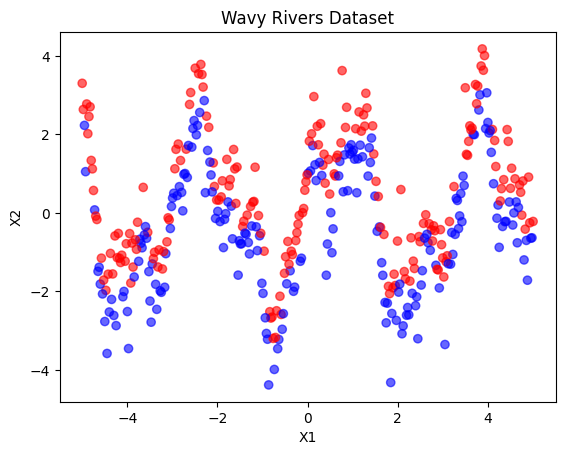


Run 0 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Run 0 Best Params: {'epochs': 400, 'lambda_scaling': 'sqrt', 'learning_rate': 0.005, 'n_control_points': 9, 'patience': 15, 'smoothing_factor': 1e-05, 'spline_type': 'cubic'}
Run 0 Score: 0.6625

Run 1 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Run 1 Best Params: {'epochs': 400, 'lambda_scaling': 'log', 'learning_rate': 0.1, 'n_control_points': 15, 'patience': 15, 'smoothing_factor': 1e-05, 'spline_type': 'cubic'}
Run 1 Score: 0.6750

Run 2 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 540 candidates, totalling 1620 fits


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_wavy_rivers(n_samples=400, noise=0.2, random_state=7):
    """
    Generate a 2D dataset with two classes separated by a squiggly, single-valued boundary.

    Parameters:
    - n_samples: Total number of points (split evenly between classes)
    - noise: Amount of random perturbation
    - random_state: Seed for reproducibility

    Returns:
    - X: 2D array of shape (n_samples, 2)
    - y: Labels array of shape (n_samples,)
    """
    np.random.seed(random_state)
    n_per_class = n_samples // 2

    # Generate x values
    x = np.linspace(-5, 5, n_samples)
    np.random.shuffle(x)
    x_class0 = x[:n_per_class]
    x_class1 = x[n_per_class:]

    # Define a squiggly boundary function (single-valued)
    boundary = (np.sin(2 * x) + 0.5 * np.cos(5 * x) + 0.3 * np.sin(10 * x)) * 2

    # Class 0: Points below the boundary with noise
    y_class0 = boundary[:n_per_class] - np.abs(np.random.normal(0, noise + 0.5, n_per_class))

    # Class 1: Points above the boundary with noise
    y_class1 = boundary[n_per_class:] + np.abs(np.random.normal(0, noise + 0.5, n_per_class))

    # Combine into dataset
    X = np.vstack([
        np.column_stack([x_class0, y_class0]),
        np.column_stack([x_class1, y_class1])
    ])
    y = np.hstack([np.zeros(n_per_class), np.ones(n_per_class)])

    # Shuffle
    perm = np.random.permutation(n_samples)
    X = X[perm]
    y = y[perm]

    return X, y

# Test it
X, y = generate_wavy_rivers(n_samples=400, noise=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6)
plt.title("Wavy Rivers Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

comparison = ClassifierComparison(X, y)

# Run all classifiers on same split
classifiers = ['smpa', 'gradient_smpa']
results = {}
for clf_type in classifiers:
    results[clf_type] = comparison.stability_test(clf_type, n_runs=10)

for clf_type, res in results.items():
    print(f"\n📊 {clf_type.upper()} Stability:")
    print(f"Mean Score: {res['mean_score']:.4f}")
    print(f"Score Std Dev: {res['std_score']:.4f}")

comparison.statistical_significance_test(results, target='smpa')